Propensity score matching
------

- https://nbviewer.jupyter.org/github/kellieotto/StatMoments/blob/master/PSM.ipynb
- https://stats.stackexchange.com/questions/206832/matched-pairs-in-python-propensity-score-matching

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def get_matching_pairs(treated_df, non_treated_df, scaler=True):

    treated_x = treated_df.values
    non_treated_x = non_treated_df.values
    if scaler == True:
        scaler = StandardScaler()
    if scaler:
        scaler.fit(treated_x)
        treated_x = scaler.transform(treated_x)
        non_treated_x = scaler.transform(non_treated_x)

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(non_treated_x)
    distances, indices = nbrs.kneighbors(treated_x)
    indices = indices.reshape(indices.shape[0])
    matched = non_treated_df.ix[indices]
    return matched

/Users/wontaek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


(-1, 2)

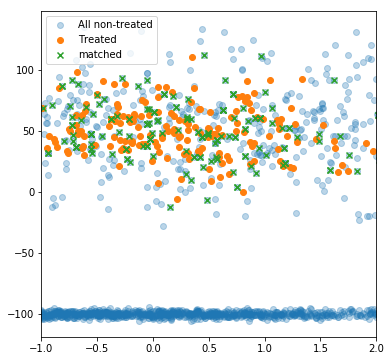

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

treated_df = pd.DataFrame()
np.random.seed(1)

size_1 = 200
size_2 = 1000
treated_df['x'] = np.random.normal(0,1,size=size_1)
treated_df['y'] = np.random.normal(50,20,size=size_1)
treated_df['z'] = np.random.normal(0,100,size=size_1)

non_treated_df = pd.DataFrame()
# two different populations
non_treated_df['x'] = list(np.random.normal(0,3,size=size_2)) + list(np.random.normal(-1,2,size=2*size_2))
non_treated_df['y'] = list(np.random.normal(50,30,size=size_2)) + list(np.random.normal(-100,2,size=2*size_2))
non_treated_df['z'] = list(np.random.normal(0,200,size=size_2)) + list(np.random.normal(13,200,size=2*size_2))


matched_df = get_matching_pairs(treated_df, non_treated_df)

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(non_treated_df['x'], non_treated_df['y'], alpha=0.3, label='All non-treated')
plt.scatter(treated_df['x'], treated_df['y'], label='Treated')
plt.scatter(matched_df['x'], matched_df['y'], marker='x', label='matched')
plt.legend()
plt.xlim(-1,2)

In [6]:
%matplotlib inline
import math
import numpy as np
import scipy
from scipy.stats import binom, hypergeom
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [7]:
names = ['Treated', 'Age', 'Education', 'Black', 'Hispanic', 'Married',
         'Nodegree', 'RE74', 'RE75', 'RE78']
treated = pd.read_table('nswre74_treated.txt', sep = '\s+',
                        header = None, names = names)
control = pd.read_table('nswre74_control.txt', sep='\s+', 
                        header = None, names = names)
data = pd.concat([treated, control])
data.head()

/Users/wontaek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/Users/wontaek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead.
  


Treated   Age  Education  Black  Hispanic  Married  Nodegree  RE74  RE75  \
0      1.0  37.0       11.0    1.0       0.0      1.0       1.0   0.0   0.0   
1      1.0  22.0        9.0    0.0       1.0      0.0       1.0   0.0   0.0   
2      1.0  30.0       12.0    1.0       0.0      0.0       0.0   0.0   0.0   
3      1.0  27.0       11.0    1.0       0.0      0.0       1.0   0.0   0.0   
4      1.0  33.0        8.0    1.0       0.0      0.0       1.0   0.0   0.0   

         RE78  
0   9930.0460  
1   3595.8940  
2  24909.4500  
3   7506.1460  
4    289.7899

In [9]:
propensity = LogisticRegression()
propensity = propensity.fit(data[names[1:-1]], data.Treated)
pscore = propensity.predict_proba(data[names[1:-1]])[:,1] # The predicted propensities by the model
print(pscore[:5])

data['Propensity'] = pscore
#pscore = pd.Series(data = pscore, index = data.index)

[0.4271837  0.25618654 0.54875769 0.37387987 0.40218954]


/Users/wontaek/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [11]:
def Match(groups, propensity, caliper = 0.05):
    ''' 
    Inputs:
    groups = Treatment assignments.  Must be 2 groups
    propensity = Propensity scores for each observation. Propensity and groups should be in the same order (matching indices)
    caliper = Maximum difference in matched propensity scores. For now, this is a caliper on the raw
            propensity; Austin reccommends using a caliper on the logit propensity.
    
    Output:
    A series containing the individuals in the control group matched to the treatment group.
    Note that with caliper matching, not every treated individual may have a match.
    '''

    # Check inputs
    if any(propensity <=0) or any(propensity >=1):
        raise ValueError('Propensity scores must be between 0 and 1')
    elif not(0<caliper<1):
        raise ValueError('Caliper must be between 0 and 1')
    elif len(groups)!= len(propensity):
        raise ValueError('groups and propensity scores must be same dimension')
    elif len(groups.unique()) != 2:
        raise ValueError('wrong number of groups')
        
        
    # Code groups as 0 and 1
    groups = groups == groups.unique()[0]
    N = len(groups)
    N1 = groups.sum(); N2 = N-N1
    g1, g2 = propensity[groups == 1], (propensity[groups == 0])
    # Check if treatment groups got flipped - treatment (coded 1) should be the smaller
    if N1 > N2:
        N1, N2, g1, g2 = N2, N1, g2, g1 
        
        
    # Randomly permute the smaller group to get order for matching
    morder = np.random.permutation(N1)
    matches = pd.Series(np.empty(N1))
    matches[:] = np.NAN
    
    for m in morder:
        dist = abs(g1[m] - g2)
        if dist.min() <= caliper:
            matches[m] = dist.argmin()
            g2 = g2.drop(matches[m])
    return (matches)

In [12]:
stuff = Match(data.Treated, data.Propensity)
g1, g2 = data.Propensity[data.Treated==1], data.Propensity[data.Treated==0]
# test ValueError
#badtreat = data.Treated + data.Hispanic
#Match(badtreat, pscore)
stuff[:5]

/Users/wontaek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


0    124.0
1    213.0
2    179.0
3    122.0
4    210.0
dtype: float64

In [16]:
for a, b in zip(g1, g2[stuff]):
    print(a, b)

0.42718369609405105 0.42586469281421435
0.25618653577986006 0.25485424478165886
0.5487576885665965 0.5642283673217289
0.3738798712878931 0.3742533744882412
0.4021895430087196 0.4025577505177387
0.3734226800359169 0.3734226800359169
0.5330258246043298 0.5370840353943495
0.3845326965218674 0.3845326965218674
0.5091596209079654 nan
0.6179679281238611 0.586913609713411
0.3670916601240088 0.3670916601240088
0.5231193615090954 0.5234178914306873
0.3700238777028932 0.37033043677157085
0.41042474883463215 0.4104868673414438
0.37296571482720875 0.3733170974030102
0.3620760887401878 0.3620760887401878
0.5366464387412189 0.5554720418663129
0.37047936814971866 0.37047936814971866
0.5710562474281683 0.5709744702230957
0.5397779448648263 0.5397779448648263
0.36544423641885876 0.36544423641885876
0.5934608443007738 0.5890891524345241
0.4387179478273636 0.4026593207340037
0.36754564695845043 0.36694510409359377
0.3599881503014407 0.3599881503014407
0.4095663174637967 0.4095663174637967
0.3696521020066